In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
from pathlib import Path
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.optimize import curve_fit

import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
def load_metadata_videos(file_path):
    return pd.read_csv(file_path).drop(columns='Unnamed: 0').dropna()

### Pipeline to extract videos and google trends related to a certain topic

In [3]:
def process_youtube_data(key_words, input_folder, output_file):
    """
    Filters videos by keywords and aggregates metrics by month.

    Args:
        key_words (list): List of keywords to search for in title and tags.

    Returns:
        pd.DataFrame: Aggregated data by month.
    """
    # Define the date range
    start_date = datetime(2008, 1, 1)
    end_date = datetime(2019, 9, 30)

    # Initialize an empty DataFrame for the final aggregated results
    aggregated_data = pd.DataFrame()

    # Process each file
    for i in range(0, 8):
        # Load the current CSV file
        file_name = f"Education_videos_{i}.csv"
        print('Processing file:', file_name)
        df_education = pd.read_csv(os.path.join(input_folder, file_name))
        print('###', df_education.shape[0], 'total videos')

        # Ensure upload_date is a datetime object
        df_education['upload_date'] = pd.to_datetime(df_education['upload_date'])

        # Filter videos by keywords in title or tags
        keyword_pattern = '|'.join(key_words)  # Create a regex pattern
        keyword_filter = (
            df_education['title'].str.contains(keyword_pattern, case=False, na=False) |
            df_education['tags'].str.contains(keyword_pattern, case=False, na=False)
        )
        filtered_df = df_education[keyword_filter]

        # Keep only videos within the date range
        filtered_df = filtered_df[(filtered_df['upload_date'] >= start_date) & (filtered_df['upload_date'] <= end_date)]
        print('###', filtered_df.shape[0], 'videos extracted')

        # Group by year and month
        filtered_df['year_month'] = filtered_df['upload_date'].dt.to_period('M')

        # print(filtered_df[(filtered_df['year_month'] == "2015-02") & (filtered_df['channel_id'] == "UCBVCi5JbYmfG3q5MEuoWdOw")].shape[0])

        # Aggregate metrics
        monthly_data = filtered_df.groupby('year_month').agg(
            videos_count=('upload_date', 'count'),
            total_view_count=('view_count', 'sum'),
            total_dislike_count=('dislike_count', 'sum'),
            total_like_count=('like_count', 'sum'),
            total_duration=('duration', 'sum')
        ).reset_index()

        # Append to the final aggregated data
        aggregated_data = pd.concat([aggregated_data, monthly_data], ignore_index=True)

    # Combine data from all files by month
    aggregated_data = aggregated_data.groupby('year_month', as_index=False).agg(
        videos_count=('videos_count', 'sum'),
        total_view_count=('total_view_count', 'sum'),
        total_dislike_count=('total_dislike_count', 'sum'),
        total_like_count=('total_like_count', 'sum'),
        total_duration=('total_duration', 'sum')
    )

    # Convert year_month back to datetime for sorting
    aggregated_data['year_month'] = pd.to_datetime(aggregated_data['year_month'].astype(str)).dt.strftime('%Y-%m')
    aggregated_data = aggregated_data.sort_values(by='year_month')

    for k in key_words:
        google_trend_path = os.path.join(input_folder, "google_trends", f"{k}.csv") #change here to the folder containing the google trend files
        if not Path(google_trend_path).is_file(): continue
        df_gt = pd.read_csv(google_trend_path, skiprows=2, header=0, names=['year_month', k])
        df_gt[k] = df_gt[k]

        aggregated_data = pd.merge(
            df_gt,
            aggregated_data,
            on='year_month',
            how='left'
        ).fillna(0)

    # Save the result to a CSV file
    aggregated_data.to_csv(output_file, index=False)

    print(f"Data saved to {output_file}")

### Pipeline to produce the plots

In [4]:
def normalize(col):
    return (col - col.min()) / (col.max() - col.min())

def exp_fit(col):

    def exponential_model(x, a, b):
        return a * np.exp(b * x)
    
    x = np.arange(col.shape[0])
    x = x / np.max(x)
    popt, pcov = curve_fit(exponential_model, x, col)
    a, b = popt
    y_fit = exponential_model(x, a, b)
    return y_fit

def trend_analysis(folder_path, key_words, config):

    file_path = os.path.join(folder_path, f"youtube_wrapped_{config['key']}.csv")
    df_wrapped = pd.read_csv(file_path)

    videos_count = normalize(df_wrapped['videos_count'])
    total_duration = normalize(df_wrapped['total_duration'])

    # Create the figure with subplots
    fig = plt.figure(figsize=(15, 8))
    gs = fig.add_gridspec(2, 2, height_ratios=[2, 1])

    # Top subplot spanning the entire width: Content creation and trends
    ax1 = fig.add_subplot(gs[0, :])
    ax1.set_title(f"{config['topic']} Popularity Over Time", fontsize=20)
    ax1.set_xlabel('Year-Month', fontsize=12)
    ax1.set_ylabel('Normalized Score', fontsize=12)
    ax1.set_ylim([-0.1, 1.1])

    # Plot videos count and total duration
    ax1.plot(df_wrapped['year_month'], videos_count, color='blue', label='Normalized Number of Videos', marker="o", linestyle='', markersize=5)
    ax1.plot(df_wrapped['year_month'], total_duration, color='blue', label='Normalized Total Duration', marker="^", linestyle='', markersize=5)

    if config['exp_fit']:
        ax1.plot(df_wrapped['year_month'], exp_fit(videos_count), color='blue', linestyle=':')
        ax1.plot(df_wrapped['year_month'], exp_fit(total_duration), color='blue', linestyle=':')

    ax1.set_xticks(df_wrapped['year_month'][::6])
    ax1.set_xticklabels(df_wrapped['year_month'][::6].astype(str), rotation=30, ha='right')
    ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), title='--> Content creation scores')

    # Twin axis for Google Trends
    ax2 = ax1.twinx()
    ax2.set_ylim([-0.1, 1.1])

    markers = ['+', 'x', '3']
    i = 0
    correlation_variables = ['videos_count', 'total_duration']

    for k in key_words[config['key']]:
        if k not in df_wrapped.columns:
            continue
        df_wrapped[k] = df_wrapped[k].apply(lambda x: int(x) if (isinstance(x, str) and x.isdigit()) or isinstance(x, int) else 0)
        ax2.plot(df_wrapped['year_month'], df_wrapped[k] / 100, color='tab:red', label=k, marker=markers[i], linestyle='-', linewidth=0.3)
        i += 1
        correlation_variables.append(k)

    ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.8), title='--> User interest scores')

    ax2.vlines(x=np.where(df_wrapped['year_month'] == '2017-08')[0][0], ymin=-1, ymax=2, colors='k', linestyles='--', linewidth=0.3)
    ax2.text(x=np.where(df_wrapped['year_month'] == '2017-08')[0][0] + 0.5, y=1.05, s='Google Trend update', color='grey')

    # Add annotations for events
    for event in config['events']:
        pos = 0.5 if event[2] == 'left' else -0.5
        ax2.vlines(x=np.where(df_wrapped['year_month'] == event[0])[0][0], ymin=-1, ymax=2, colors='k', linestyles='-', linewidth=1)
        ax2.text(x=np.where(df_wrapped['year_month'] == event[0])[0][0] + pos, y=-0.09, s=event[1], color='k', fontsize=15, horizontalalignment=event[2])

    # Bottom-left subplot: Seasonal decomposition
    if config['key'] == 'ML': df_wrapped.loc[85, "videos_count"] = (df_wrapped.loc[84, "videos_count"]+df_wrapped.loc[86, "videos_count"])/2 #remove outlier for seasonality analysis
    ax3 = fig.add_subplot(gs[1, 0])
    result = seasonal_decompose(df_wrapped['videos_count'], model='additive', period=12)
    ax3.plot(result.observed, label="Observed", color='blue')
    ax3.plot(result.trend, label="Trend", color='orange')
    ax3.plot(result.seasonal, label="Seasonal", color='green')
    ax3.set_title('Trend and Seasonality in the Number of Videos', fontsize=15)
    ax3.set_ylabel('Scores', fontsize=12)
    ax3.set_xlabel('Year', fontsize=12)
    ax3.set_xticks(ticks=np.arange(0,140,12), labels=np.arange(2008, 2020), rotation=30, fontsize=10, ha='right')
    ax3.legend(loc='upper left')
    # Set y-limits based on the result data
    y_min = min(result.observed.min(), result.trend.min(), result.seasonal.min())
    y_max = max(result.observed.max(), result.trend.max(), result.seasonal.max())
    y_range = y_max-y_min
    ax3.set_ylim([y_min - 0.1*y_range, y_max + 0.1*y_range])

    # Add annotations for events
    for event in config['events']:
        ax3.vlines(x=np.where(df_wrapped['year_month'] == event[0])[0][0], ymin=-10000, ymax=10000, colors='k', linestyles='-', linewidth=1)

    # Bottom-right subplot: Correlation heatmap
    ax4 = fig.add_subplot(gs[1, 1])
    correlation = df_wrapped[correlation_variables].corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax4, annot_kws={'size': 13})
    ax4.set_title('Correlation Heatmap: Content Creation vs. Google Trends', fontsize=15)
    ax4.set_yticklabels(ax4.get_yticklabels(), rotation=30, fontsize=10, va='top')
    ax4.set_xticklabels(ax4.get_yticklabels(), rotation=30, fontsize=10, ha='right')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()


### Variables

In [5]:
key_words = {'ML': ['machine learning', 'deep learning', 'artificial intelligence'],
             'crypto': ['crypto', 'cryptocurrency', 'bitcoin', 'ethereum', 'binance'],
             'ebola': ['ebola'],
             'osama': ['bin laden', 'jihadi', 'al-qaeda'],
             'feminism': ['feminism', 'metoo', '#metoo', 'me too', 'gender equality', ' misoginy', 'toxic masculanity']}

configs = {'ML': {'key': 'ML',
                  'topic': 'Machine learning and AI',
                  'exp_fit': True,
                  'events': [('2012-09', 'AlexNet', 'left'), ('2016-03', 'AlphaGo', 'left')]},
           'crypto': {'key': 'crypto',
                      'topic': 'Cryptocurrency',
                      'exp_fit': False,
                      'events': [('2014-02', 'Mt. Gox Hack', 'left'), ('2017-01', 'Crypto Bubble', 'left')]},
           'ebola': {'key': 'ebola',
                     'topic': 'Ebola Disease',
                     'exp_fit': False,
                     'events': [('2013-12', 'Outbreak', 'right'), ('2014-08', 'Public Health Emergency', 'left')]},
           'osama': {'key': 'osama',
                     'topic': 'Bin Laden and Al-Qaeda',
                     'exp_fit': False,
                     'events': [('2011-05', 'Bin Laden Death', 'right'), ('2013-04', 'ISIS', 'left'), ('2015-01', 'Charlie Hebdo', 'left')]},
           'feminism': {'key': 'feminism',
                        'topic': 'Gender Equality and Feminism',
                        'exp_fit': True,
                        'events': [('2014-08', 'GamerGate', 'left'), ('2017-10', 'Weinstein', 'left')]}}

folder = r"C:\Users\Flori\Docs\Python\M2_S3_ADA\Project - data"

In [ ]:
key = 'ML' # possible keys are: ML, crypto, ebola, osama, feminism
output_file = os.path.join(folder, f'youtube_wrapped_{key}.csv')
process_youtube_data(key_words=key_words['feminism'], input_folder=folder, output_file=output_file)

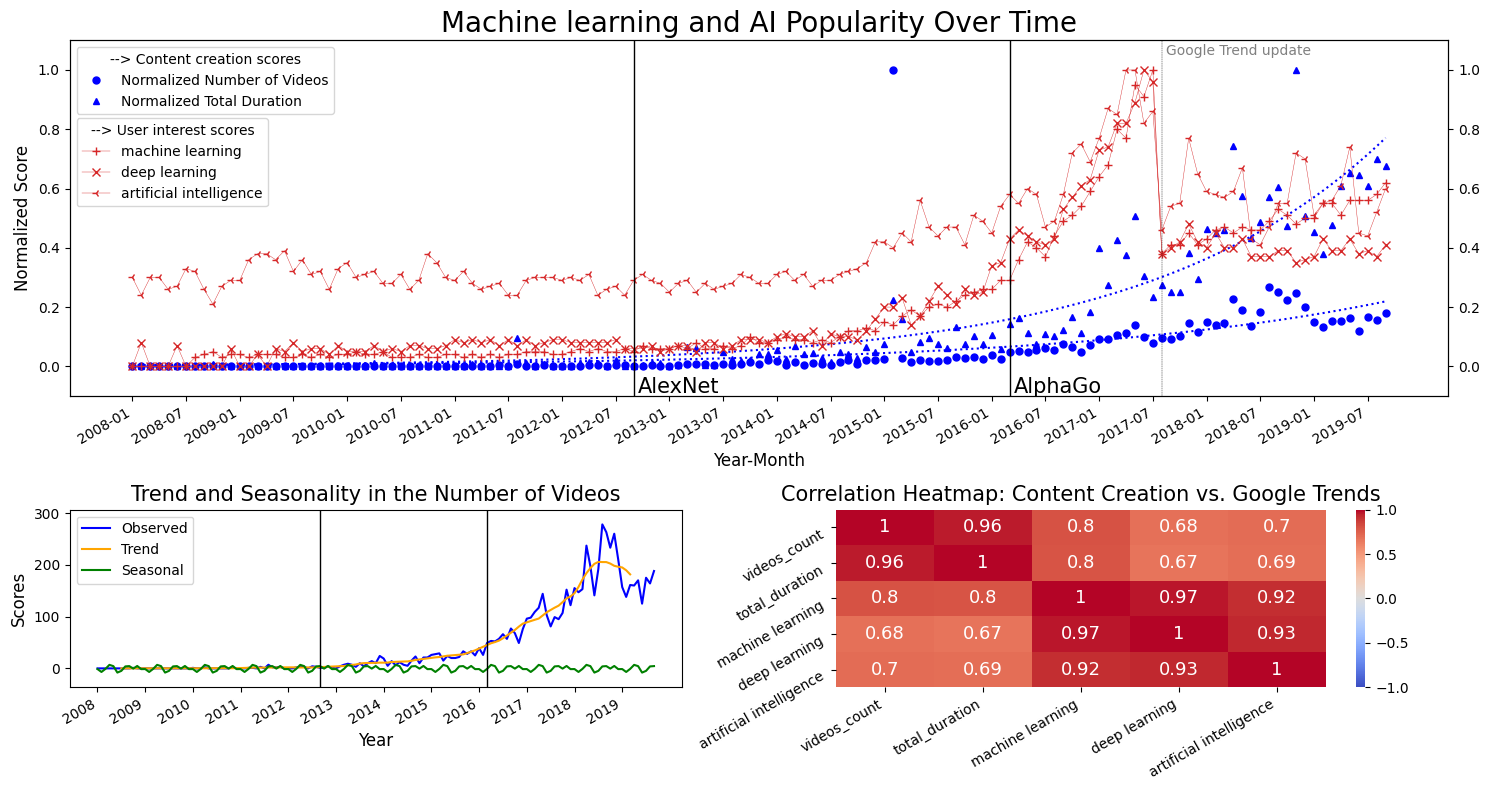

In [7]:
key = 'ML' # possible keys are: ML, crypto, ebola, osama, feminism
output_file = os.path.join(folder, f'youtube_wrapped_{key}.csv')
trend_analysis(folder_path=folder, key_words=key_words, config=configs[key]) 

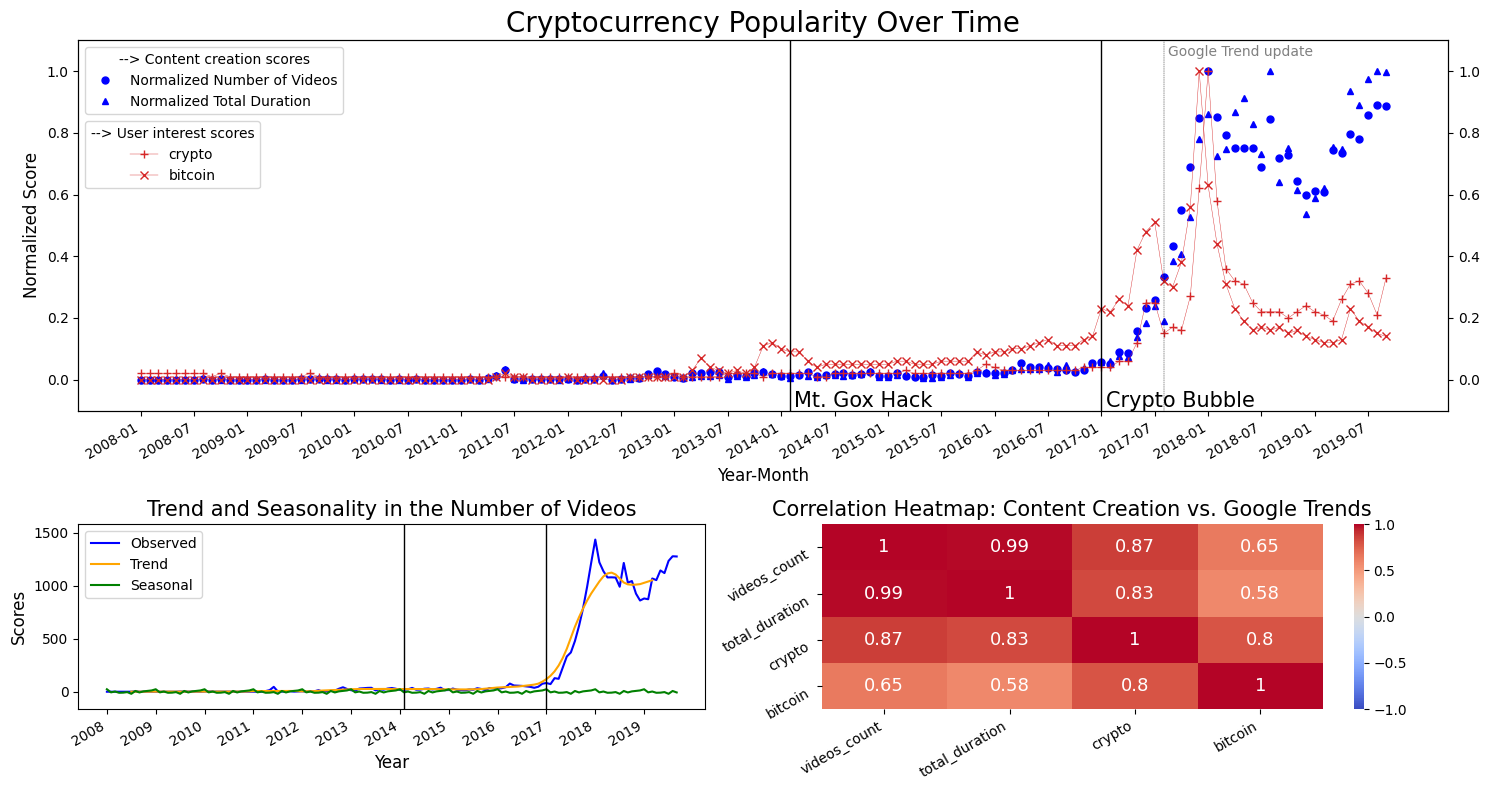

In [8]:
key = 'crypto' # possible keys are: ML, crypto, ebola, osama, feminism
output_file = os.path.join(folder, f'youtube_wrapped_{key}.csv')
trend_analysis(folder_path=folder, key_words=key_words, config=configs[key]) 

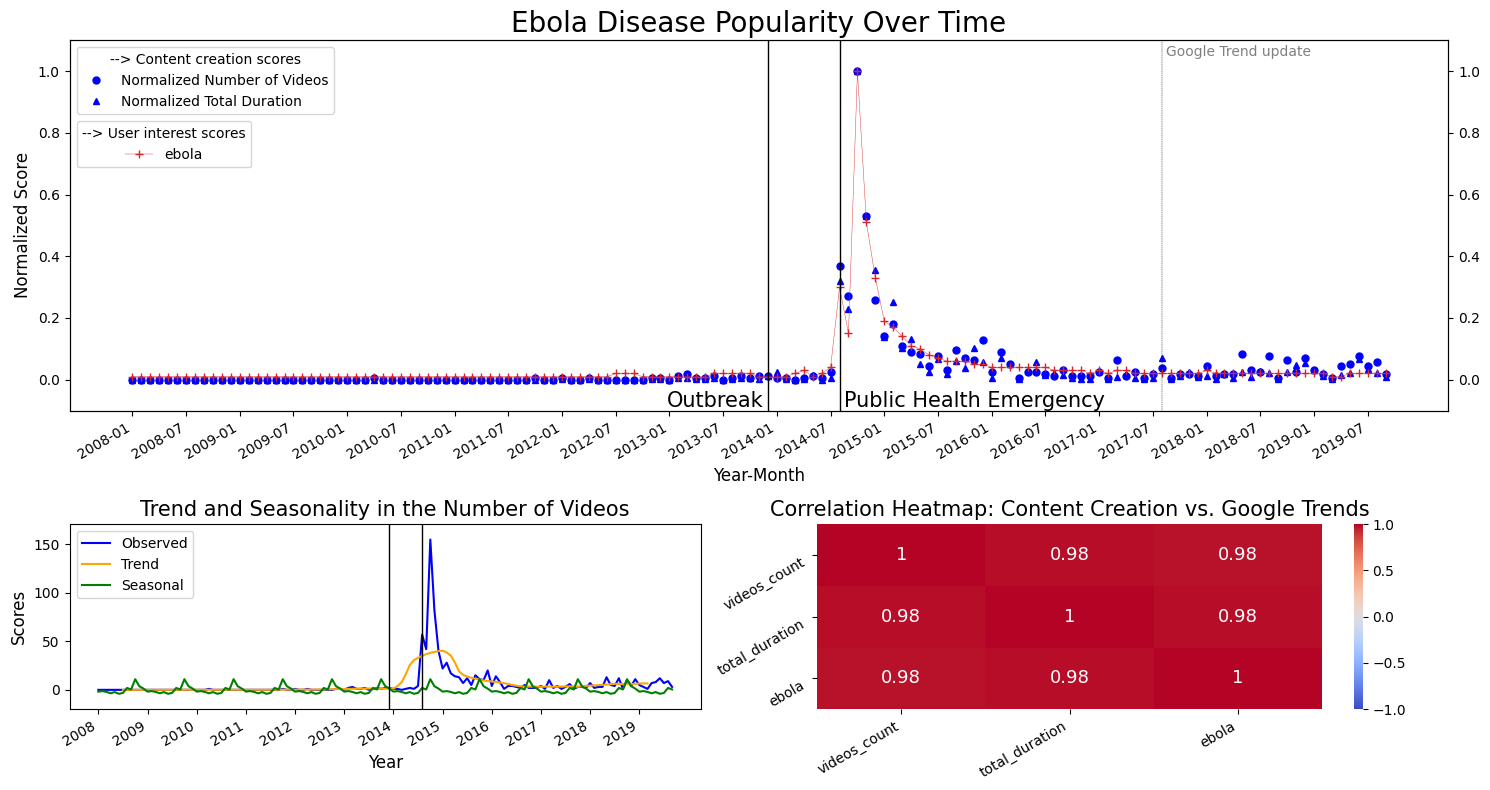

In [9]:
key = 'ebola' # possible keys are: ML, crypto, ebola, osama, feminism
output_file = os.path.join(folder, f'youtube_wrapped_{key}.csv')
trend_analysis(folder_path=folder, key_words=key_words, config=configs[key]) 

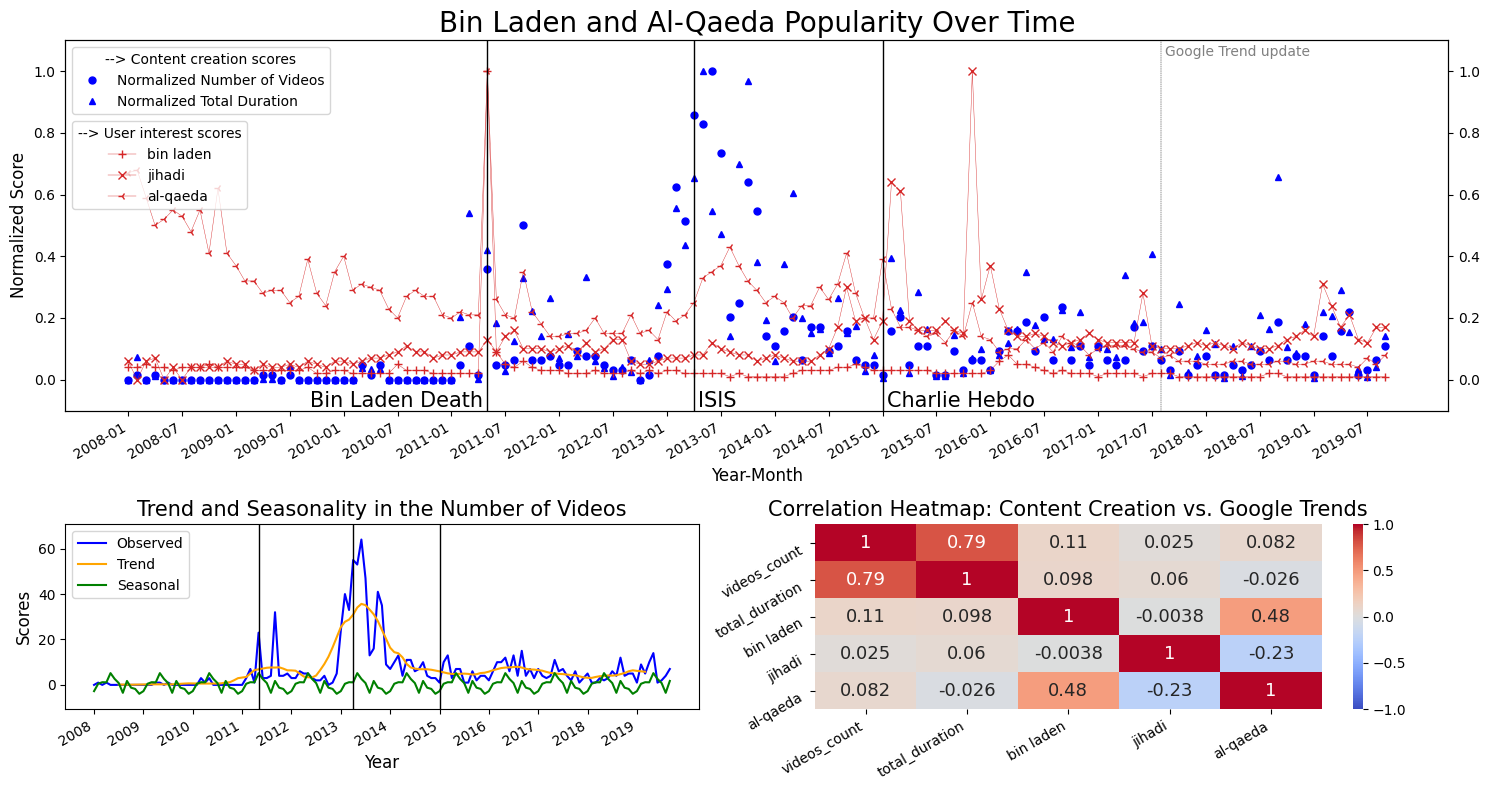

In [10]:
key = 'osama' # possible keys are: ML, crypto, ebola, osama, feminism
output_file = os.path.join(folder, f'youtube_wrapped_{key}.csv')
trend_analysis(folder_path=folder, key_words=key_words, config=configs[key]) 

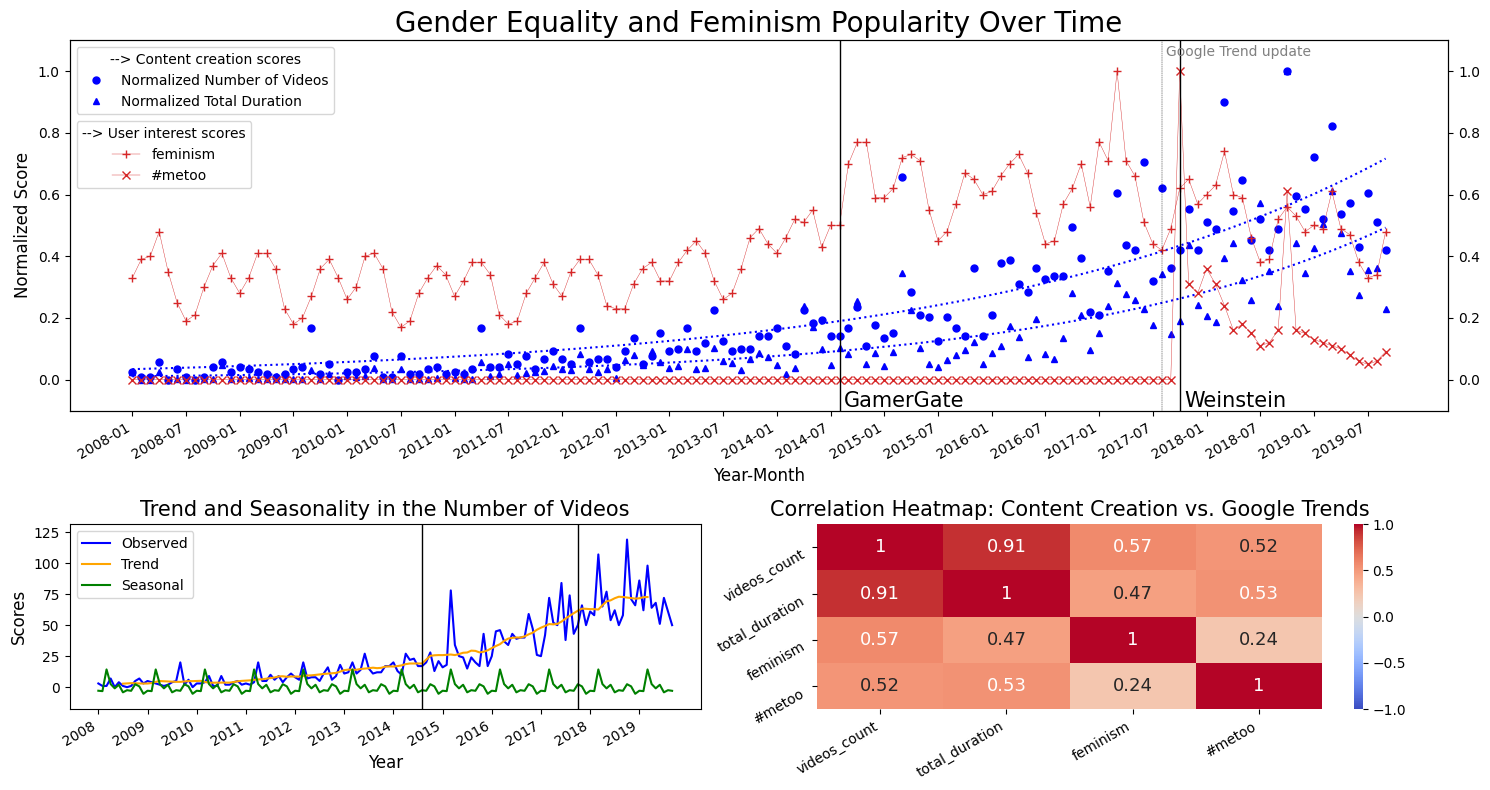

In [11]:
key = 'feminism' # possible keys are: ML, crypto, ebola, osama, feminism
output_file = os.path.join(folder, f'youtube_wrapped_{key}.csv')
trend_analysis(folder_path=folder, key_words=key_words, config=configs[key]) 